In [1]:
import sys
sys.path.append('bulkfood/')

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

def draw_figure(num, **kwargs):
    
    settings = {
        'right': 2,
        'top': 1.5,
    }
    for key, val in kwargs.items():
        settings[key] = val
    
    path = 'figure/fig20_{}.png'.format(num)
    img = imageio.imread(path)
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img)
    ax.axis('off')
    fig.subplots_adjust(**settings)

# Chapter 20. 속성 디스크립터
* \_\_get\_\_(), \_\_set\_\_(), \_\_delete\_\_() 메서드로 구성된 프로토콜을 구현하는 클래스
    * 예: property
* 대부분은 \_\_get\_\_(), \_\_set\_\_()만 구현하며 하나만 구현하는 경우도 많음

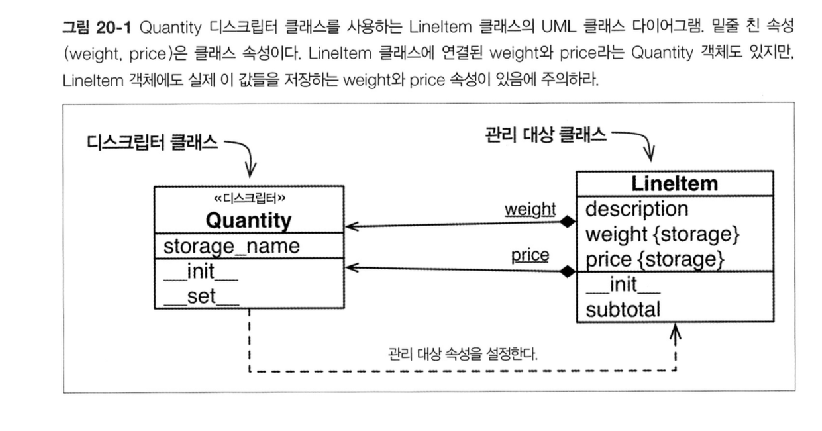

In [2]:
draw_figure(1)

## 20.1 디스크립터 예: 속성 검증
* 디스크립터 클래스: 디스크립터 프로토콜 구현하는 클래스 (Quantity 클래스)
* 관리 대상 클래스: 디스크립터 객체를 클래스 속성을 선언하는 클래스 (LineItem 클래스)
* 디스크립터 객체: 관리 대상 클래스의 클래스 속성으로 선언된, 디스크립터 클래스의 객체
* 관리 대상 객체: 관리 대상 클래스의 객체
* 저장소 속성: 관리 대상 객체 안의 관리 대상 속성값을 담을 속성 (weight, price)
* 관리 대상 속성: 디스크립터 객체에 의해 관리되는 관리 대상 클래스 안의 공개 속성, 저장소 속성에 저장됨

## 20.1.1 간단한 디스크립터

### 예제 20-1: LineItem의 속성을 관리하는 Quantity 디스크립터
* \_\_set\_\_():
    * self: 디스크립터 객체
    * instance: 관리 대상 객체
* 속성명을 반복하는 단점이 있음

In [151]:
class Quantity:  # <1>

    def __init__(self, storage_name):
        self.storage_name = storage_name  # <2>

    def __set__(self, instance, value):  # <3>
        if value > 0:
            instance.__dict__[self.storage_name] = value  # <4> setattr 쓰면 무한 재귀
        else:
            raise ValueError('value must be > 0')


class LineItem:
    weight = Quantity('weight')  # <5>
    price = Quantity('price')  # <6>

    def __init__(self, description, weight, price):  # <7>
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price

In [152]:
item = LineItem('White truffle', 100, 3)

In [153]:
print(item)

In [159]:
truffle = LineItem('White truffle', 100, 0)

ValueError: value must be > 0

## 20.1.2 자동 저장소 속성명

### 예제 20-2: 이름 중복 피하기
* 이름 중복을 피하기 위해 Quantity 객체의 storage_name에 대한 고유 문자열 생성 (예: \_Quantity\#0)

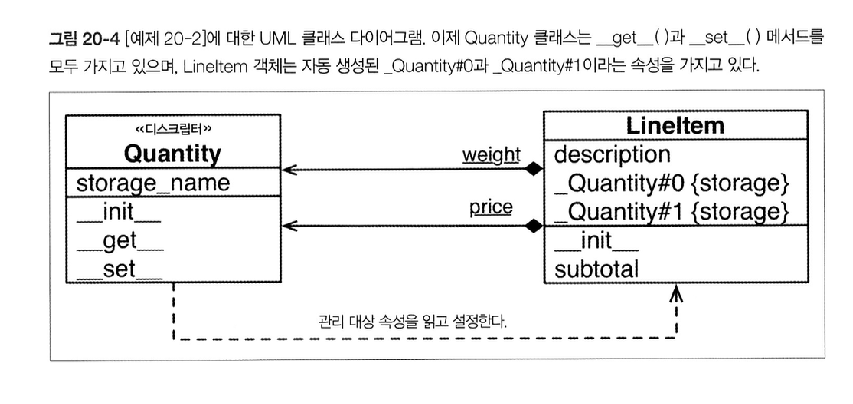

In [7]:
draw_figure(4)

In [163]:
class Quantity:
    __counter = 0  # <1>

    def __init__(self):
        cls = self.__class__  # <2>
        prefix = cls.__name__
        index = cls.__counter
        self.storage_name = '_{}#{}'.format(prefix, index)  # <3> 저장소 속성 명
        cls.__counter += 1  # <4>

    def __get__(self, instance, owner):  # <5>
        return getattr(instance, self.storage_name)  # <6>

    def __set__(self, instance, value):
        if value > 0:
            setattr(instance, self.storage_name, value)  # <7>
        else:
            raise ValueError('value must be > 0')


class LineItem:
    weight = Quantity()  # <8> 관리대상 속성 명
    price = Quantity()

    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price


In [165]:
LineItem.__dict__

mappingproxy({'__dict__': <attribute '__dict__' of 'LineItem' objects>,
              '__doc__': None,
              '__init__': <function __main__.LineItem.__init__>,
              '__module__': '__main__',
              '__weakref__': <attribute '__weakref__' of 'LineItem' objects>,
              'price': <__main__.Quantity at 0x7fda092e7b00>,
              'subtotal': <function __main__.LineItem.subtotal>,
              'weight': <__main__.Quantity at 0x7fda092e77f0>})

In [166]:
item = LineItem('White truffle', 100, 3)

In [167]:
print(item.__dict__)

{'description': 'White truffle', '_Quantity#0': 100, '_Quantity#1': 3}


In [168]:
item.weight = 20

In [169]:
print(item.__dict__)

{'description': 'White truffle', '_Quantity#0': 20, '_Quantity#1': 3}


In [170]:
print(LineItem.__dict__)

{'__module__': '__main__', 'weight': <__main__.Quantity object at 0x7fda092e77f0>, 'price': <__main__.Quantity object at 0x7fda092e7b00>, '__init__': <function LineItem.__init__ at 0x7fda0c3ac158>, 'subtotal': <function LineItem.subtotal at 0x7fda0c3ac268>, '__dict__': <attribute '__dict__' of 'LineItem' objects>, '__weakref__': <attribute '__weakref__' of 'LineItem' objects>, '__doc__': None}


In [171]:
LineItem.weight = 1

In [172]:
print(item.__dict__)

{'description': 'White truffle', '_Quantity#0': 20, '_Quantity#1': 3}


In [173]:
print(LineItem.__dict__)

{'__module__': '__main__', 'weight': 1, 'price': <__main__.Quantity object at 0x7fda092e7b00>, '__init__': <function LineItem.__init__ at 0x7fda0c3ac158>, 'subtotal': <function LineItem.subtotal at 0x7fda0c3ac268>, '__dict__': <attribute '__dict__' of 'LineItem' objects>, '__weakref__': <attribute '__weakref__' of 'LineItem' objects>, '__doc__': None}


### 예제 20-3: 클래스 속성을 바로 가져올때는 디스크립터 자신을 반환

In [178]:
class Quantity:
    __counter = 0

    def __init__(self):
        cls = self.__class__
        prefix = cls.__name__
        index = cls.__counter
        self.storage_name = '_{}#{}'.format(prefix, index)
        cls.__counter += 1

    def __get__(self, instance, owner):
        if instance is None:
            return self  # <1>
        else:
            return getattr(instance, self.storage_name)  # <2>

    def __set__(self, instance, value):
        if value > 0:
            setattr(instance, self.storage_name, value)
        else:
            raise ValueError('value must be > 0')
# END LINEITEM_V4B


class LineItem:
    weight = Quantity()
    price = Quantity()

    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price

In [179]:
print(LineItem.weight)

In [180]:
item = LineItem('White truffle', 100, 3)

In [181]:
print(item.weight)

100


* 고작 두개의 속성을 관리하려고 이짓을 해야되나?  
$\Rightarrow$ 프레임워크를 개발할 경우, Quantity 클래스 비슷한 녀석들을 한곳에 모아놓고 사용할수 있음
* 또한 클래스 상속을 통해 재사용이 가능함 (20.1.3절)
* 장고 모델가 디스크립터라고 함

### 예제 20-4: 디스크립터 모듈 정의

* model_v4c

``` python
# BEGIN MODEL_V4
class Quantity:
    __counter = 0

    def __init__(self):
        cls = self.__class__
        prefix = cls.__name__
        index = cls.__counter
        self.storage_name = '_{}#{}'.format(prefix, index)
        cls.__counter += 1

    def __get__(self, instance, owner):
        if instance is None:
            return self
        else:
            return getattr(instance, self.storage_name)

    def __set__(self, instance, value):
        if value > 0:
            setattr(instance, self.storage_name, value)
        else:
            raise ValueError('value must be > 0')
# END MODEL_V4

```

In [182]:
# BEGIN LINEITEM_V4C
import model_v4c as model  # <1>


class LineItem:
    weight = model.Quantity()  # <2>
    price = model.Quantity()

    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price
# END LINEITEM_V4C


* 단점:
    - **\_Quantity\#0**처럼 복잡한 이름을 써야됨
    - 관리대상 속성(weight, price)와 비슷한 이름을 사용하려면 클래스 데커레이터나 메타클래스가 필요 (21장)

* c.f. 팩토리 함수
    - 디스크립터 클래스는 상속이 가능 (재사용)
    - 함수 속성과 클로저에 상태를 저장하는것보다 클래스와 객체 속성에 저장하는 것이 더 간단

``` python
# BEGIN LINEITEM_V4_PROP
def quantity():  # <1>
    try:
        quantity.counter += 1  # <2>
    except AttributeError:
        quantity.counter = 0  # <3>

    storage_name = '_{}:{}'.format('quantity', quantity.counter)  # <4>

    def qty_getter(instance):  # <5>
        return getattr(instance, storage_name)

    def qty_setter(instance, value):
        if value > 0:
            setattr(instance, storage_name, value)
        else:
            raise ValueError('value must be > 0')

    return property(qty_getter, qty_setter)
# END LINEITEM_V4_PROP

class LineItem:
    weight = quantity()
    price = quantity()

    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price

```

## 20.1.3 새로운 디스크립터형 (description 검증 추가)
* 템플릿 메서드 디자인 패턴:  
서브클래스가 구체적인 동작을 구현하기 위해 오버라이드하는 추상적인 연산의 관점에서 알고리즘 정의

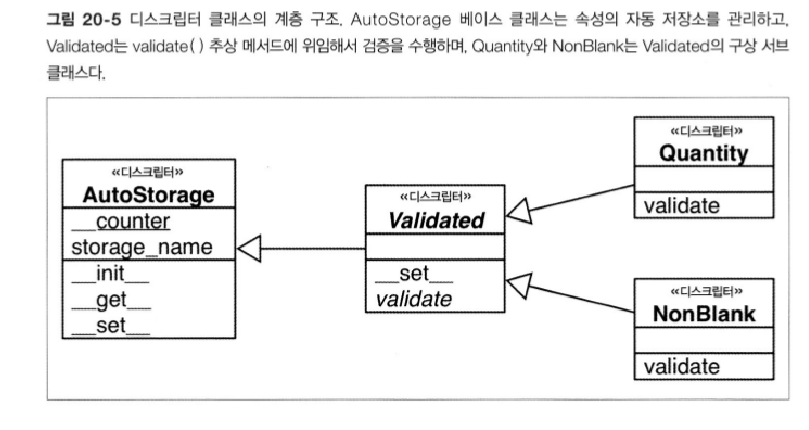

In [23]:
draw_figure(5)

### 예제 20-6, 7: 리팩토링한 디스크립터 클래스
* model_v5

``` python
# BEGIN MODEL_V5
import abc


class AutoStorage:  # <1> Quantity 디스크립터가 제공하던 기능과 거의 동일
    __counter = 0

    def __init__(self):
        cls = self.__class__
        prefix = cls.__name__
        index = cls.__counter
        self.storage_name = '_{}#{}'.format(prefix, index)
        cls.__counter += 1

    def __get__(self, instance, owner):
        if instance is None:
            return self
        else:
            return getattr(instance, self.storage_name)

    def __set__(self, instance, value):
        setattr(instance, self.storage_name, value)  # <2> Quantity 디스크립터와 이 부분만 다름 (검증 부분은 서브클래스로 넘김)


class Validated(abc.ABC, AutoStorage):  # <3> 추상클래스

    def __set__(self, instance, value):
        value = self.validate(instance, value)  # <4>
        super().__set__(instance, value)  # <5>

    @abc.abstractmethod
    def validate(self, instance, value):  # <6> 이 녀석을 각 서브클래스가 구현해야됨 (abstractmethod)
        """return validated value or raise ValueError"""


class Quantity(Validated):  # <7>
    """a number greater than zero"""

    def validate(self, instance, value):
        if value <= 0:
            raise ValueError('value must be > 0') # 수량 0 이상인지 검사
        return value


class NonBlank(Validated):
    """a string with at least one non-space character"""

    def validate(self, instance, value):
        value = value.strip()
        if len(value) == 0: # 설명이 유효한지 검사
            raise ValueError('value cannot be empty or blank')
        return value  # <8>

# END MODEL_V5
```

In [183]:
# BEGIN LINEITEM_V5
import model_v5 as model  # <1>


class LineItem:
    description = model.NonBlank()  # <2>
    weight = model.Quantity()
    price = model.Quantity()

    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price
# END LINEITEM_V5


In [184]:
LineItem('', 20, 10)

ValueError: value cannot be empty or blank

In [188]:
LineItem('valid', 20, 10)

* 정리
    - 지금까지의 디스크립터는 오버라이딩 디스크립터
        - \_\_set\_\_() 메서드가 관리 대상 객체 (item) 안에 있는 동일한 이름의 속성(weight, price)설정을 오버라이드(가로채서 변경)
        - 다음절에서는 논오버라이딩 디스크립터를 살펴보자

## 20.2 오버라이딩/논오버라이딩 디스크립터

In [27]:
# BEGIN DESCR_KINDS

### auxiliary functions for display only ###

def cls_name(obj_or_cls):
    cls = type(obj_or_cls) # main namaspace에서의 class
    if cls is type:
        cls = obj_or_cls
    return cls.__name__.split('.')[-1] # 클래스 이름

def display(obj):
    cls = type(obj)
    if cls is type: # type 클래스면
        return '<class {}>'.format(obj.__name__)
    elif cls in [type(None), int]: # None이나 int 클래스
        return repr(obj)
    else: # 기타 오브젝트
        return '<{} object>'.format(cls_name(obj))

def print_args(name, *args):
    pseudo_args = ', '.join(display(x) for x in args)
    print('-> {}.__{}__({})'.format(cls_name(args[0]), name, pseudo_args)) # 클래스 이름_메서드 이름_나머지 args

In [235]:
### essential classes for this example ###

class Overriding:  # <1> 오버라이딩 디스크립터 (get, set)
    """a.k.a. data descriptor or enforced descriptor"""

    def __get__(self, instance, owner):
        print_args('get', self, instance, owner)  # <2>

    def __set__(self, instance, value):
        print_args('set', self, instance, value)


class OverridingNoGet:  # <3> 오버라이딩 디스크립터 (get이 없는)
    """an overriding descriptor without ``__get__``"""

    def __set__(self, instance, value):
        print_args('set', self, instance, value)


class NonOverriding:  # <4> 논오버라이딩 디스크립터 (set이 없음)
    """a.k.a. non-data or shadowable descriptor"""

    def __get__(self, instance, owner):
        print_args('get', self, instance, owner)


class Managed:  # <5> 관리대상 클래스
    over = Overriding()
    over_no_get = OverridingNoGet()
    non_over = NonOverriding()

    def spam(self):  # <6> 메서드가 디스크립터이기도 함 (비교용)
        print('-> Managed.spam({})'.format(display(self)))

# END DESCR_KINDS


## 20.2.1 오버라이딩 디스크립터

### 예제 20-8: 디스크립터 오버라이딩 동작 확인
* print\_args: |class name|.\_\_|method name|\_\_(|self|\_|instance|\_\owner or value|)

In [191]:
obj = Managed()

In [193]:
print(obj.over)

-> Overriding.__get__(<Overriding object>, <Managed object>, <class Managed>)
None


In [194]:
print(Managed.over)

-> Overriding.__get__(<Overriding object>, None, <class Managed>)
None


In [195]:
obj.over = 7

-> Overriding.__set__(<Overriding object>, <Managed object>, 7)


* 여전히 \_\_get\_\_() 메서드를 통해 가져옴

In [196]:
print(obj.over)

-> Overriding.__get__(<Overriding object>, <Managed object>, <class Managed>)
None


In [197]:
print(obj.__dict__)

{}


* 우회해보면?

In [198]:
obj.__dict__['over'] = 8

In [199]:
print(vars(obj))

{'over': 8}


* 여전히 Managed.over 디스크립터가 개입

In [200]:
print(obj.over)

-> Overriding.__get__(<Overriding object>, <Managed object>, <class Managed>)
None


In [201]:
print(obj.__dict__)

{'over': 8}


## 20.2.2 오버라이팅 디스크립터 (\_\_get\_\_()이 없는)

### 예제 20-10: OverridingNoGet 디스크립터

In [202]:
obj = Managed()

In [203]:
print(obj.over_no_get)

In [204]:
print(Managed.over_no_get)

In [205]:
obj.over_no_get = 7

-> OverridingNoGet.__set__(<OverridingNoGet object>, <Managed object>, 7)


* 값을 변경하진 않음

In [206]:
print(obj.over_no_get)

In [207]:
print(obj.__dict__)

{}


* \_\_dict\_\_()를 통해 객체 속성 설정

In [208]:
obj.__dict__['over_no_get'] = 9

In [209]:
print(obj.__dict__)

{'over_no_get': 9}


* 디스크립터를 가림

In [210]:
print(obj.over_no_get)

9


* 값 할당은 여전히 \_\_set\_\_() 거침

In [211]:
obj.over_no_get = 7

-> OverridingNoGet.__set__(<OverridingNoGet object>, <Managed object>, 7)


In [212]:
print(obj.__dict__)

{'over_no_get': 9}


* 동일한 이름의 객체 속성이 있으면 그 녀석을 가져옴

In [213]:
print(obj.over_no_get)

9


## 20.2.3 논오버라이딩 디스크립터
* \_\_set\_\_()이 없음
* 동일한 이름의 객체 속성 설정하면 디스크립터를 가리므로 디스크립터가 더이상 작동하지 않음

### 예 20-11: 논오버라이딩 디스크립터

In [221]:
obj = Managed()

* \_\_get\_\_() 호출

In [222]:
print(obj.non_over)

-> NonOverriding.__get__(<NonOverriding object>, <Managed object>, <class Managed>)
None


* 할당에 개입하는 \_\_set\_\_()이 없음

In [224]:
obj.non_over = 7

* over의 non_over라는 객체 속성이 Managed 클래스에 있는 동일한 이름의 디스크립터 속성을 가림

In [226]:
print(obj.non_over)

7


* Managed는 디스크립터 여전히 존재하므로 읽기 연산 가로챔

In [228]:
print(Managed.non_over)

-> NonOverriding.__get__(<NonOverriding object>, None, <class Managed>)
None


* non_ver 객체 속성 제거

In [229]:
del obj.non_over

* 클래스 안에 있는 디스크립터의 \_\_get()\_\_() 메서드가 호출

In [230]:
print(obj.non_over)

-> NonOverriding.__get__(<NonOverriding object>, <Managed object>, <class Managed>)
None


* \_\_set\_\_() 메서드 존재 여부에 따라 결과가 달라지는것 확인
* 클래스 안의 속성은 디스크립터가 통제할 수 없음 (클래스 속성에 값을 할당함으로써 디스크립터 객체 자신이 무용지물 될수도)  
$\Rightarrow$ 20.2.4절에서 확인

## 20.2.4 클래스 안에서 디스크립터 덮어 쓰기

In [231]:
obj = Managed()

### 예 20-12: 클래스 자체를 이용해서 디스크립터 덮어쓰기

In [232]:
Managed.over = 1
Managed.over_no_get = 2
Managed.non_over = 3

In [233]:
print(obj.over, obj.over_no_get, obj.non_over)

1 2 3


In [234]:
del Managed.over

## 20.3 메서드는 디스크립터
* 모든 사용자 정의 함수는 \_\_get\_\_() 메서드를 가지고 있고, 클래스에 연결된 함수는 디스크립터로 작동함
* 클래스 안의 함수는 클래스에 바인딩된 메서드가 됨
* 드디어 spam을 사용...

### 예 20-13: 메서드는 논오버라이딩 디스크립터!

In [237]:
obj = Managed()

In [239]:
print(obj.spam)

<bound method Managed.spam of <__main__.Managed object at 0x7fda092db3c8>>


In [240]:
print(Managed.spam)

<function Managed.spam at 0x7fda092a9840>


In [241]:
obj.spam = 7

* 클래스 속성을 가림 (논오버라이딩 디스크립터)

In [245]:
print(obj.spam)

<bound method Managed.spam of <__main__.Managed object at 0x7fda092db3c8>>


In [249]:
del obj.spam

AttributeError: spam

In [247]:
print(obj.spam)

<bound method Managed.spam of <__main__.Managed object at 0x7fda092db3c8>>


* obj.spam과 Managed.spam은 다른 객체 반환
    - 관리 대상 클래스(Managed)를 통해 객체에 접근할 때 함수의 \_\_get\_\_() 메서드는 자기 자신 반환
    - 객체를 통해 함수에 접근할 때는 함수의 \_\_get\_\_() 함수가 바인딩된 메서드 객체를 반환
        - 메서드는 functools.partial() 함수처럼 관리 대상 객체(obj)를 함수의 첫 번째 인수(self)에 바인딩하는 콜러블 객체

### 예제 20-14, 15: method_is_descriptor.py

In [258]:
# BEGIN FUNC_DESCRIPTOR_EX
import collections


class Text(collections.UserString):

    def __repr__(self):
        return 'Text({!r})'.format(self.data)

    def reverse(self):
        return self[::-1]

# END FUNC_DESCRIPTOR_EX

In [259]:
word = Text('forward')

* Text객체의 표현(repr)은 동일한 객체 생성하기 위해 호출하는 Text() 생성자 호출과 동일

In [260]:
print(repr(word))

Text('forward')


In [261]:
print(word.reverse())

drawrof


* 클래스에 호출한 메서드는 함수로 작동

In [68]:
print(Text.reverse(Text('backward')))

drawkcab


* 각 자료형은 function/method

In [69]:
print(type(Text.reverse), type(word.reverse))

<class 'function'> <class 'method'>


* Text이외의 객체에 대해서도 하나의 function처럼 작동

In [70]:
print(list(map(Text.reverse, ['repaid', (10, 20, 30), Text('stressed')])))

['diaper', (30, 20, 10), Text('desserts')]


* 모든 함수는 논오버라이딩 디스크립터  
객체를 전달해서 함수의 \_\_get\_\_() 메서드를 호출하면 그 객체에 바인딩된 메서드가 반환

In [274]:
print(Text.reverse.__get__(word))

<bound method Text.reverse of Text('forward')>


* instance 인수로 None을 전달해서 함수의 \_\_get\_\_() 메서드 호출하면 함수 자신이 반환

In [272]:
print(Text.reverse.__get__(None, Text))

<function Text.reverse at 0x7fda092b2f28>


* word.reverse의 표현식은 실제로는 Text.rever.\_\_get\_\_(word)를 호출하므로 바인딩된 메서드 반환

In [275]:
print(word.reverse)

<bound method Text.reverse of Text('forward')>


* 바인딩된 메서드 객체는 \_\_self\_\_ 속성에 호출된 객체에 대한 참조를 담고 있음

In [276]:
print(word.reverse.__self__)

forward


* 바인딩된 메서드의 \_\_func\_\_() 속성은 관리 대상 클래스의 연결된 원래 함수 참조

In [278]:
print(word.reverse.__func__() is Text.reverse)

True


## 20.4 디스크립터 사용에 대한 조언
#### 코드를 간결하게 작성하기 위해 프로퍼티 사용
* proprety() 내장 함수는 세터 메서드 정의하지 않아도 \_\_set\_\_()과 \_\_get\_\_() 메서드를 모두 구현하는 오버라이딩 디스크립터 생성
* 프로퍼티의 기본 \_\_set\_\_() 메서드는 **AttributeError: can't set attribute**예외를 발생시키므로, 프로퍼티는 읽기 전용 속성 만들기에 가장 간단한 방법

#### 읽기 전용 디스크립터는 \_\_set\_\_()을 구현해야 됨
* 디스크립터 클래스로 읽기 전용 속성 구현하려면 \_\_get\_\_(), \_\_set\_\_() 메서드 모두 구현해야 됨
* 그렇지 않으면, 객체가 동일한 이름의 속성 가질 때 디스크립터가 가려짐
* **읽기 전용 속성의 \_\_set\_\_() 메서드는 적절한 메시지 담아 **AttributeError 발생시켜야 됨!**

#### 검증 디스크립터는 \_\_set\_\_()만 사용할 수 있음
* 검증하기 위한 디스크립터는 \_\_set\_\_() 메서드만 이용해서 값의 정당성 검증
* 값이 정당한 경우 디스크립터 객체명과 동일한 이름의 속성을 \_\_dict\_\_에 직접 설정
* 이렇게 하면 디스크립터 객체명과 동일한 이름의 속성 읽을 때 \_\_get\_\_() 거치지 않으므로 더 빨리 읽을 수 있음 (예제20-1 참고)

#### 캐시는 \_\_get\_\_()에서만 효율적으로 구현할 수 있음
* \_\_get\_\_()만 구현하면 논오버라이딩 디스크립터가 됨
* 논오버라이딩 디스크립터는 값비싼 연산 수생하고 객체에 있는 동일명의 속성에 결과를 저장해서 캐시할 때 유용
* 동일명의 객체 속성이 디스크립터를 가리므로, 이후에 이 속성 읽을 때 디스크립터의 \_\_get\_\_() 메서드 대신 \_\_dict\_\_에서 바로 가져옴

#### 특별 메서드 이외의 메서드는 객체 속성에 의해 가려질 수 있음
* 함수와 메서드는 \_\_get\_\_()만 구현하므로 동일한 이름의 객체 속성을 저장하는 연산은 간섭하지 않음
* 따라서 `my_obj.the_method = 7` 과 같이 할당할 때, **클래스와 다른 객체에는 영향 미치지 않고**, **my_object의 the_method를 읽을때만 7 반환**
* 파이썬 인터프리터는 클래스 자체에 있는 특별 메서드를 먼저 검색
    - 예:  
    `repr(x)` $\rightarrow$ `x.__class__.__repr__(x)`를 호출

## Appendix
### A1.

In [76]:
class Quantity:  # <1>

    def __init__(self, storage_name):
        self.storage_name = storage_name  # <2>
        
    def __set__(self, instance, value):  # <3>
        if value > 0:
            instance.__dict__[self.storage_name] = value  # <4> setattr 쓰면 무한 재귀
        else:
            raise ValueError('value must be > 0')    

class LineItem:
    weight = Quantity('weight')  # <5>
    price = Quantity('price')  # <6>

    def __init__(self, description, weight, price):  # <7>
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price

In [77]:
print(LineItem.__dict__)

{'__module__': '__main__', 'weight': <__main__.Quantity object at 0x7fda0c41f4a8>, 'price': <__main__.Quantity object at 0x7fda0c410358>, '__init__': <function LineItem.__init__ at 0x7fda0c37ed90>, 'subtotal': <function LineItem.subtotal at 0x7fda0c37ed08>, '__dict__': <attribute '__dict__' of 'LineItem' objects>, '__weakref__': <attribute '__weakref__' of 'LineItem' objects>, '__doc__': None}


In [78]:
print(item.__dict__)

{'description': 'White truffle', '_Quantity#0': 100, '_Quantity#1': 3}


In [79]:
item = LineItem('test', 20, 20)

In [80]:
class Quantity:  # <1>

    def __init__(self, storage_name):
        self.storage_name = storage_name  # <2>

    def __get__(self, instance, owner):  # <5>
        print(instance, owner, self.storage_name)
        return getattr(instance, self.storage_name)  # <6>
#         return instance.__dict__[self.storage_name]  # <6>
        
    def __set__(self, instance, value):  # <3>
        if value > 0:
            print(instance, self.storage_name)
#             setattr(instance, self.storage_name, value)
            instance.__dict__[self.storage_name] = value  # <4> setattr 쓰면 무한 재귀
        else:
            raise ValueError('value must be > 0')


class LineItem:
    weight = Quantity('weight')  # <5>
    price = Quantity('price')  # <6>

    def __init__(self, description, weight, price):  # <7>
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.pricew

In [81]:
item = LineItem('test', 20, 20)

<__main__.LineItem object at 0x7fda0c390c50> weight
<__main__.LineItem object at 0x7fda0c390c50> price


In [82]:
item.__dict__

{'description': 'test', 'price': 20, 'weight': 20}

In [83]:
getattr(item, 'weight')

<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390c50> <class '__main__.LineItem'> weight
<__main__.LineItem object at 0x7fda0c390

RecursionError: maximum recursion depth exceeded in comparison

In [92]:
class Quantity:
    __counter = 0  # <1>

    def __init__(self):
        cls = self.__class__  # <2>
        prefix = cls.__name__
        index = cls.__counter
        self.storage_name = '_{}#{}'.format(prefix, index)  # <3>
        cls.__counter += 1  # <4>

    def __get__(self, instance, owner):  # <5>
        print(instance, owner, self.storage_name)
        return getattr(instance, self.storage_name)  # <6>
    
    def __getattr__(self):
        print(2)

    def __set__(self, instance, value):
        if value > 0:
            print(self, self.storage_name, instance, value)
            setattr(instance, self.storage_name, value)  # <7>
        else:
            raise ValueError('value must be > 0')


class LineItem:
    weight = Quantity()  # <8>
    price = Quantity()    

    def __init__(self, description, weight, price):
        print(self.__dict__)
        
        self.description = description
        self.weight = weight
        self.price = price
        
        print(self.__dict__)

    def subtotal(self):
        return self.weight * self.price

In [93]:
item = LineItem('test', 20, 20)

{}
<__main__.Quantity object at 0x7fda0c4acb00> _Quantity#0 <__main__.LineItem object at 0x7fda09303ba8> 20
<__main__.Quantity object at 0x7fda0c4ac198> _Quantity#1 <__main__.LineItem object at 0x7fda09303ba8> 20
{'description': 'test', '_Quantity#0': 20, '_Quantity#1': 20}


In [94]:
type(item).__dict__

mappingproxy({'__dict__': <attribute '__dict__' of 'LineItem' objects>,
              '__doc__': None,
              '__init__': <function __main__.LineItem.__init__>,
              '__module__': '__main__',
              '__weakref__': <attribute '__weakref__' of 'LineItem' objects>,
              'price': <__main__.Quantity at 0x7fda0c4ac198>,
              'subtotal': <function __main__.LineItem.subtotal>,
              'weight': <__main__.Quantity at 0x7fda0c4acb00>})

In [95]:
item1 = LineItem('test', 20, 20)
item2 = LineItem('test', 20, 20)

{}
<__main__.Quantity object at 0x7fda0c4acb00> _Quantity#0 <__main__.LineItem object at 0x7fda09303f98> 20
<__main__.Quantity object at 0x7fda0c4ac198> _Quantity#1 <__main__.LineItem object at 0x7fda09303f98> 20
{'description': 'test', '_Quantity#0': 20, '_Quantity#1': 20}
{}
<__main__.Quantity object at 0x7fda0c4acb00> _Quantity#0 <__main__.LineItem object at 0x7fda09303fd0> 20
<__main__.Quantity object at 0x7fda0c4ac198> _Quantity#1 <__main__.LineItem object at 0x7fda09303fd0> 20
{'description': 'test', '_Quantity#0': 20, '_Quantity#1': 20}


In [96]:
item.weight

<__main__.LineItem object at 0x7fda09303ba8> <class '__main__.LineItem'> _Quantity#0


20

In [97]:
item.__dict__

{'_Quantity#0': 20, '_Quantity#1': 20, 'description': 'test'}

In [98]:
getattr(item, '_Quantity#0')

20

## References
* understanding how descriptor works:  
https://www.blog.pythonlibrary.org/2016/06/10/python-201-what-are-descriptors/
* slots:  
https://stackoverflow.com/questions/472000/usage-of-slots
* \_\_set\_\_ vs \_\_setattr\_\_:  
https://stackoverflow.com/questions/10707206/what-is-the-difference-between-set-and-setattr-in-python-and-when-should  
https://stackoverflow.com/questions/3798835/understanding-get-and-set-and-python-descriptors
* \_\_getattribute\_\_() vs \_\_getattr\_\_():  
https://stackoverflow.com/questions/44991609/how-is-getattr-related-to-object-getattribute-and-to-object-getattr
* property vs descriptor vs \_\_getattribute\_\_:  
https://stackoverflow.com/questions/22616559/use-cases-for-property-vs-descriptor-vs-getattribute
* getattr vs \_\_dict\_\_:  
https://stackoverflow.com/questions/14084897/getattr-versus-dict-lookup-which-is-faster

In [99]:
class A(object):
    x = 10
    def __getattribute__(self, attr):
        print(f'Looking up {attr!r}')
        return object.__getattribute__(self, attr)
    def __getattr__(self, attr):
        print(f'Invoked the fallback method for missing {attr!r}')
        return 42

In [100]:
a = A()

Looking up '__class__'
Looking up '__class__'


In [101]:
print(a.x)

Looking up 'x'
10


In [102]:
print(a.y)

Looking up 'y'
Invoked the fallback method for missing 'y'
42


* `getattr(x, 'a')` $\equiv$ `x.a`

In [103]:
print(getattr(a, 'x'))

Looking up 'x'
10


In [104]:
print(getattr(a, 'y'))

Looking up 'y'
Invoked the fallback method for missing 'y'
42
